In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

STOPWORDS = set(stopwords.words('indonesian'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

NORMALIZATION_DICT = {
    'gak': 'tidak','ga': 'tidak','gk': 'tidak','ngga': 'tidak','nggak': 'tidak',
    'yg': 'yang','dgn': 'dengan','utk': 'untuk','pd': 'pada','krn': 'karena',
    'tdk': 'tidak','sdh': 'sudah','blm': 'belum','jg': 'juga','jd': 'jadi',
    'klo': 'kalau','kalo': 'kalau','tp': 'tetapi','dr': 'dari','dg': 'dengan',
    'sm': 'sama','lg': 'lagi','org': 'orang','thn': 'tahun','bln': 'bulan',
    'hr': 'hari','bgt': 'banget','bs': 'bisa','emg': 'memang','emang': 'memang',
    'mkn': 'makan','msh': 'masih','trs': 'terus','sgt': 'sangat','sy': 'saya',
    'kpd': 'kepada','shg': 'sehingga','dl': 'dalam','dll': 'dan lain lain',
    'dsb': 'dan sebagainya','dst': 'dan seterusnya',
    'wkwk': '','haha': '','hehe': '','hihi': ''
}

def clean_text(text):
    if pd.isna(text): return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def case_folding(text):
    return text.lower()

def normalize_text(text):
    words = text.split()
    normalized = []
    for w in words:
        if w in NORMALIZATION_DICT:
            if NORMALIZATION_DICT[w] != "":
                normalized.append(NORMALIZATION_DICT[w])
        else:
            normalized.append(w)
    return " ".join(normalized)

def preprocess_pipeline(text):
    text = clean_text(text)
    text = case_folding(text)
    text = normalize_text(text)
    return text


In [2]:
df = pd.read_csv('data_prelabeled_full.csv')

df = df.dropna(subset=['aspect','context','polaritas'])
df['aspect_clean'] = df['aspect'].apply(preprocess_pipeline)
df['context_clean'] = df['context'].apply(preprocess_pipeline)

df['polaritas'] = df['polaritas'].str.lower().str.strip()

label_map = {'negatif':0,'netral':1,'positif':2,'negative':0,'neutral':1,'positive':2}
inv_label_map = {0:'negatif',1:'netral',2:'positif'}

df['label'] = df['polaritas'].map(label_map)
df = df.dropna(subset=['label'])

df['text'] = (df['aspect_clean'] + " " + df['context_clean']).str.strip()
df = df[df['text'] != ""]

df.head()


,rating,original,aspect,context,polaritas,aspect_clean,context_clean,label,text
0,1,saat di lapangan tidak seindah saat di aplikas...,Aplikasi,saat di lapangan tidak seindah saat di aplikas...,negatif,aplikasi,saat di lapangan tidak seindah saat di aplikas...,0,aplikasi saat di lapangan tidak seindah saat d...
1,1,"sudah bayar di app presisi logo biru, sekarang...",Pembayaran,"sudah bayar di app presisi logo biru, sekarang...",negatif,pembayaran,"sudah bayar di app presisi logo biru, sekarang...",0,pembayaran sudah bayar di app presisi logo bir...
2,1,"sudah bayar di app presisi logo biru, sekarang...",Aplikasi,"sudah bayar di app presisi logo biru, sekarang...",negatif,aplikasi,"sudah bayar di app presisi logo biru, sekarang...",0,"aplikasi sudah bayar di app presisi logo biru,..."
3,1,Perlu di perbarui untuk jadwal kerja. Diketera...,Kemudahan,Agar akses bisa lebih mudah dan tidak terlalu ...,negatif,kemudahan,agar akses bisa lebih mudah dan tidak terlalu ...,0,kemudahan agar akses bisa lebih mudah dan tida...
4,1,min plisss ini kenapa bikin SKCK menunggu pemb...,Pembayaran,min plisss ini kenapa bikin SKCK menunggu pemb...,negatif,pembayaran,min plisss ini kenapa bikin skck menunggu pemb...,0,pembayaran min plisss ini kenapa bikin skck me...


In [3]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

y_train = train_df['label'].values
y_test = test_df['label'].values

print("Train:", len(train_df), " | Test:", len(test_df))


Train: 2339  | Test: 585


In [ ]:
import random

# Kamus Sinonim lebih lengkap
AUG_SYNONYM = {
    "bagus": ["baik", "mantap", "oke", "keren"],
    "buruk": ["jelek", "parah", "tidak bagus", "kurang"],
    "error": ["bug", "masalah", "kendala"],
    "crash": ["force close", "tutup sendiri"],
    "lemot": ["lambat", "slow", "lelet"],
    "lambat": ["lemot", "slow"],
    "cepat": ["kilat", "langsung", "gesit"],
    "loading": ["memuat", "proses"],
    "fitur": ["feature", "menu", "fungsi"],
    "update": ["pembaruan", "upgrade"],
    "login": ["masuk", "sign in"],
    "logout": ["keluar", "sign out"],
    "akun": ["account", "profil"],
    "otp": ["kode verifikasi", "kode keamanan", "verification code"],
    "kode": ["OTP", "security code"],
    "layanan": ["service", "pelayanan"],
    "aplikasi": ["app", "platform", "software"],
    "susah": ["ribet", "rumit"],
    "mudah": ["simple", "gampang"],
    "gagal": ["tidak berhasil", "failed"],
    "berhasil": ["sukses", "ok"],
    "tidak": ["ga", "nggak"],
}

def augment_text(text, p=0.25):
    """Augmentasi sederhana: ganti kata dengan sinonim berdasarkan probabilitas p"""
    words = text.split()
    new_words = []

    for w in words:
        w_lower = w.lower()
        if w_lower in AUG_SYNONYM and random.random() < p:
            new_words.append(random.choice(AUG_SYNONYM[w_lower]))
        else:
            new_words.append(w)

    return " ".join(new_words)


# Proses augmentasi
augmented_rows = []

for idx, row in train_df.iterrows():
    new_text = augment_text(row['text'])
    if new_text != row['text']:
        augmented_rows.append({
            'text': new_text,
            'label': row['label']
        })

aug_df = pd.DataFrame(augmented_rows)

# Gabungkan training data + augmented
train_df_aug = pd.concat([train_df, aug_df], ignore_index=True)

print("Before augmentation:", len(train_df))
print("After augmentation :", len(train_df_aug))

train_df = train_df_aug
y_train = train_df['label'].values


Before augmentation: 2339
After augmentation : 3370


In [5]:
MODEL_NAME = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert_model.eval()

def get_bert_embeddings(texts, batch_size=8):  # batch_size diperkecil agar aman
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
            batch = texts[i:i+batch_size]

            encoded = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )

            input_ids = encoded['input_ids'].to(device)
            mask = encoded['attention_mask'].to(device)

            outputs = bert_model(input_ids=input_ids, attention_mask=mask)
            last_hidden = outputs.last_hidden_state

            mask_expanded = mask.unsqueeze(-1).expand(last_hidden.size()).float()
            sum_embeddings = torch.sum(last_hidden * mask_expanded, dim=1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)

            mean_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            embeddings.append(mean_embeddings)

    return np.vstack(embeddings)


# GENERATE EMBEDDING SETELAH AUGMENTASI
X_train = get_bert_embeddings(train_df['text'].tolist())
X_test  = get_bert_embeddings(test_df['text'].tolist())

X_train.shape, X_test.shape


Embedding: 100%|██████████| 74/74 [00:22<00:00,  3.34it/s]


((3370, 768), (585, 768))

In [6]:
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

X_train_bal.shape, np.unique(y_train_bal, return_counts=True)


((8742, 768), (array([0, 1, 2]), array([2914, 2914, 2914])))

In [7]:
# ==========================================
# OVERSAMPLING
# ==========================================
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print("Balanced shape:", X_train_bal.shape)


# ==========================================
# SCALING
# ==========================================
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled  = scaler.transform(X_test)


# ==========================================
# PCA
# ==========================================
from sklearn.decomposition import PCA

pca = PCA(n_components=150, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("PCA shape:", X_train_pca.shape)


# ==========================================
# TRAIN NAIVE BAYES
# ==========================================
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_pca, y_train_bal)

print("Training selesai")


Balanced shape: (8742, 768)
PCA shape: (8742, 150)
Training selesai


Test Accuracy: 0.7145299145299145

Classification Report:
              precision    recall  f1-score   support

     negatif       0.92      0.75      0.82       505
      netral       0.07      0.21      0.10        14
     positif       0.29      0.56      0.38        66

    accuracy                           0.71       585
   macro avg       0.42      0.51      0.44       585
weighted avg       0.83      0.71      0.76       585



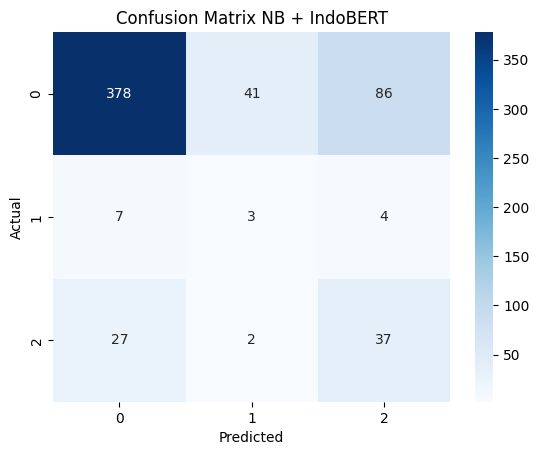

In [8]:
y_pred = nb.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negatif','netral','positif']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix NB + IndoBERT")
plt.show()


In [9]:
import pickle

pipeline = {
    'scaler': scaler,
    'pca': pca,
    'nb': nb,
    'label_map': label_map,
    'inv_label_map': inv_label_map
}

with open("indobert_nb_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

"Pipeline saved!"


'Pipeline saved!'